In [1]:
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme="onedork", context="notebook", ticks=True, grid=True)

import numpy as np
import itertools
import h5py
import os
import sys
import glob

import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import pandas as pd
import tikzplotlib

# from tqdm import tqdm
from tqdm.notebook import tqdm_notebook as tqdm

import helper.circular

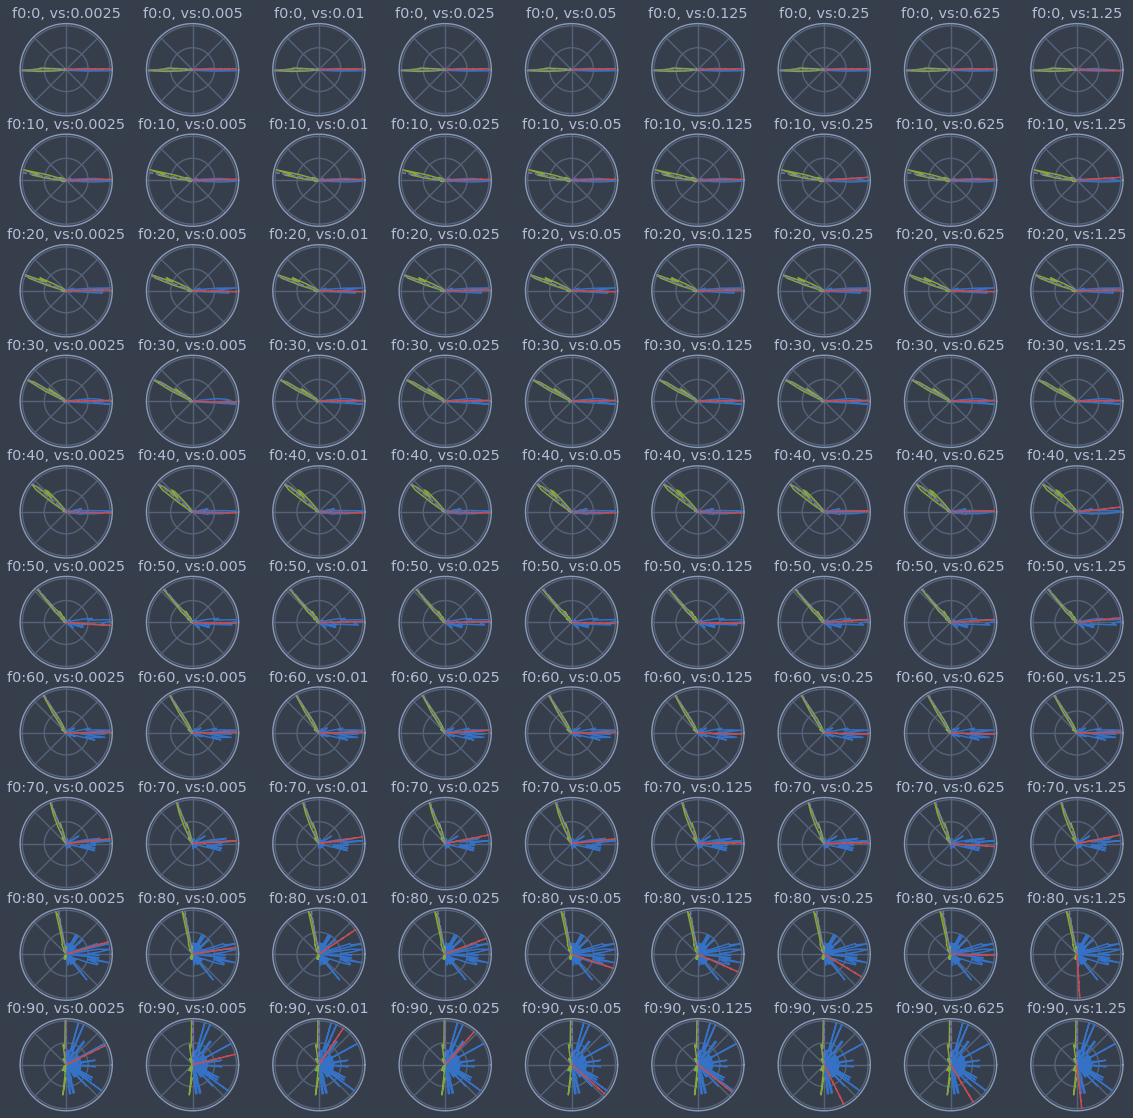

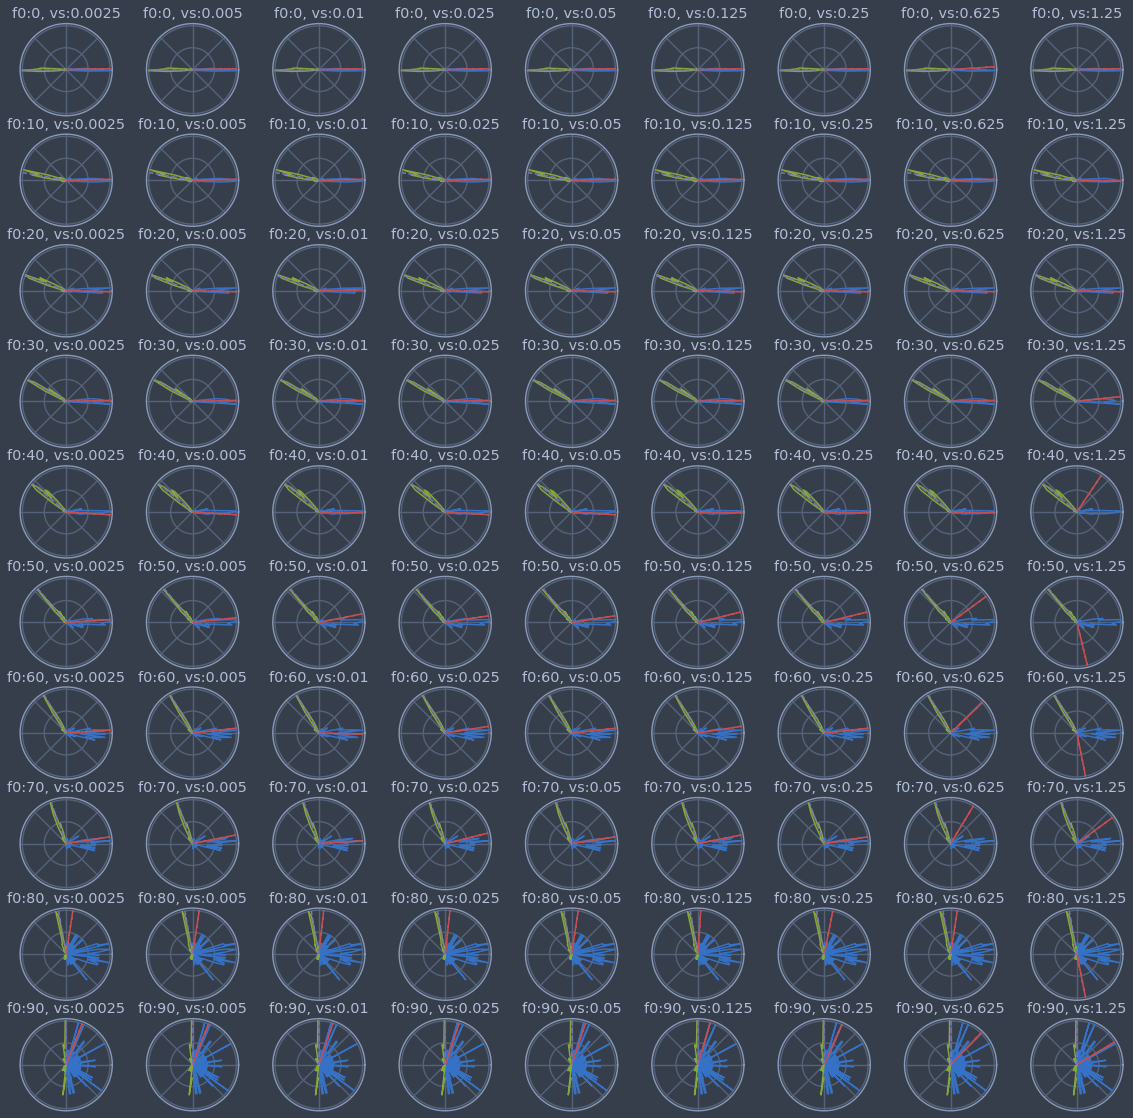

In [2]:
# hist_bin = lambda n: np.linspace(0, np.pi, n + 1, endpoint=True)

df = pd.read_pickle(os.path.join("output/vs_0/voxel_size_simulation.pkl"))

for model in df.model.unique():

    fig, axs = plt.subplots(len(df.f0_inc.unique()),
                            len(df.voxel_size.unique()),
                            subplot_kw={'projection': 'polar'},
                            figsize=(20, 20))
    axs = np.atleast_2d(axs)

    for i, f0_inc in enumerate(sorted(df.f0_inc.unique())):
        for j, vs in enumerate(sorted(df.voxel_size.unique())):
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
            axs[i, j].set_title(f"f0:{f0_inc:.0f}, vs:{vs}")

    for i, f0_inc in enumerate(sorted(df.f0_inc.unique())):
        for j, vs in enumerate(sorted(df.voxel_size.unique())):

            sub = (df.omega == 0.0) & (df.psi == 1.0) & (df.f1_rot == 0.0) & (
                df.voxel_size == vs) & (df.f0_inc == f0_inc) & (df.model
                                                                == model)

            df_sub = df[sub]

            if len(df_sub) > 1:
                print("fooo", omega, psi)
            if len(df_sub) == 0:
                continue

            phi = df_sub.explode("f_phi").f_phi.to_numpy(float)
            theta = df_sub.explode("f_theta").f_theta.to_numpy(float)
            phi, phi_inc = helper.circular.orientation_sph_plot(phi, theta)

            h, x = np.histogram(phi,
                                np.linspace(-np.pi / 2,
                                            np.pi / 2,
                                            4 * 18 + 1,
                                            endpoint=True),
                                density=True)
            x = x[:-1] + (x[1] - x[0]) / 2
            h = h / np.amax(h)
            axs[i, j].plot(x, h)

            h, x = np.histogram(phi_inc,
                                np.linspace(np.pi / 2,
                                            3 * np.pi / 2,
                                            4 * 18 + 1,
                                            endpoint=True),
                                density=True)
            x = x[:-1] + (x[1] - x[0]) / 2
            h = h / np.amax(h)
            axs[i, j].plot(x, h)

            phi = df_sub.explode("epa_dir").epa_dir.to_numpy(float)
            phi[phi > np.pi] -= 2 * np.pi
            phi[phi > np.pi / 2] -= np.pi
            h, x = np.histogram(phi,
                                np.linspace(-np.pi / 2,
                                            np.pi / 2,
                                            4 * 18 + 1,
                                            endpoint=True),
                                density=True)
            x = x[:-1] + (x[1] - x[0]) / 2
            h = h / np.amax(h)
            axs[i, j].plot(x, h, '--')
            axs[i,
                j].plot([np.deg2rad(180 - f0_inc),
                         np.deg2rad(180 - f0_inc)], [0, 1], '--')

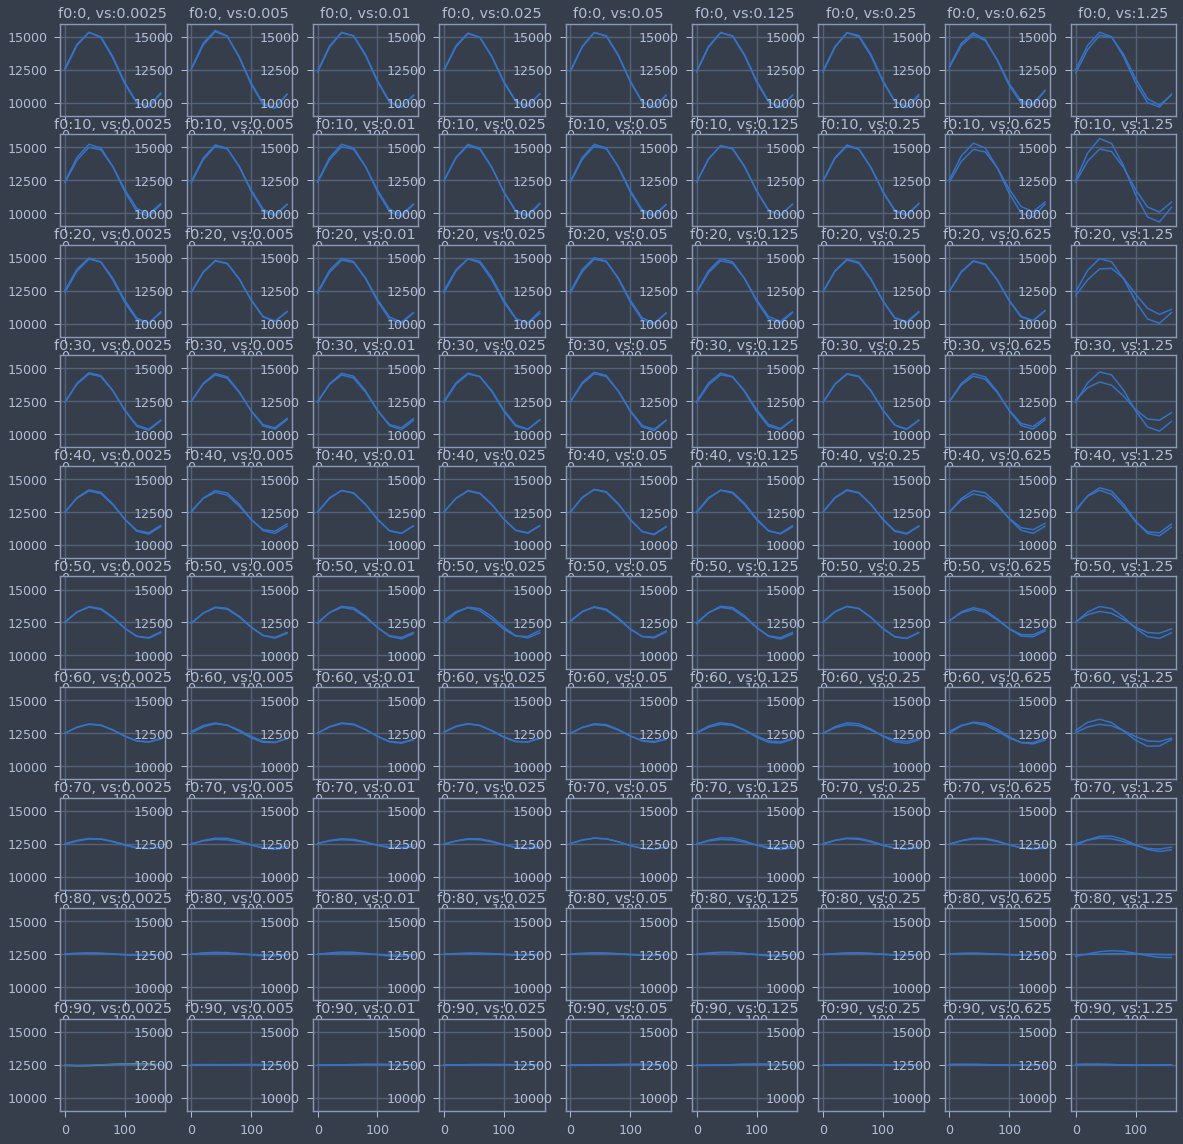

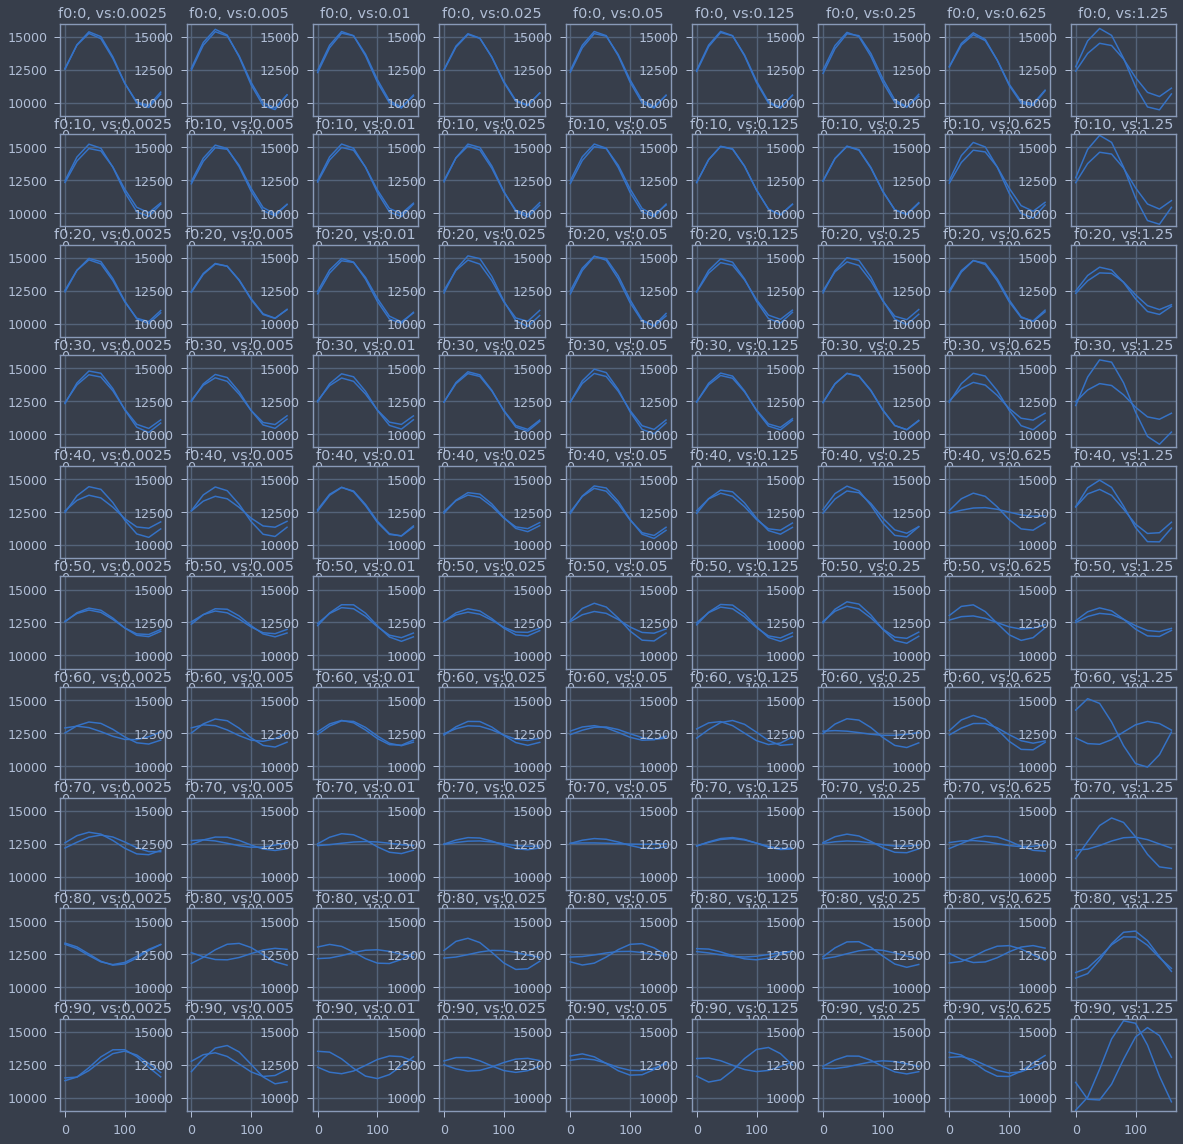

In [3]:
if False:
    hist_bin = lambda n: np.linspace(0, np.pi, n + 1, endpoint=True)

    df = pd.read_pickle(
        os.path.join("output/repeat_test_1/voxel_size_simulation.pkl"))
    # df = df[df.voxel_size >= 0.1]

    for model in tqdm(df.model.unique(), leave=True):

        fig, axs = plt.subplots(
            len(df.f0_inc.unique()),
            len(df.voxel_size.unique()),
            # subplot_kw={'projection': 'polar'},
            figsize=(20, 20))
        axs = np.atleast_2d(axs)
        x = np.linspace(0, 180, df.iloc[0]['optic'].shape[-1], False)

        for i, f0_inc in enumerate(sorted(df.f0_inc.unique())):
            for j, vs in enumerate(sorted(df.voxel_size.unique())):
                axs[i, j].set_ylim((9000, 16000))
                axs[i, j].set_title(f"f0:{f0_inc:.0f}, vs:{vs}")

        for i, f0_inc in enumerate(
                tqdm(sorted(df.f0_inc.unique()), leave=False)):
            for j, vs in enumerate(
                    tqdm(sorted(df.voxel_size.unique()), leave=False)):
                for n in tqdm(df.n.unique(), leave=False):
                    sub = (df.omega == 0.0) & (df.psi == 1.0) & (
                        df.f1_rot == 0.0) & (df.voxel_size == vs) & (
                            df.f0_inc == f0_inc) & (df.model == model) & (df.n
                                                                          == n)
                    df_sub = df[sub]
                    for m, row in df_sub.iterrows():
                        optic = row['optic']
                        if m == 0:
                            color = 'g'
                        else:
                            color = 'b'
                        if m != 0 and m % 4 != 0:
                            continue

                        axs[i, j].plot(x, optic, color)

In [4]:
df = pd.read_pickle(
    os.path.join("output/repeat_test_1/voxel_size_simulation.pkl"))

# df = df[(df.omega == 0.0) & (df.psi == 1.0) & (df.f1_rot == 0.0)]
df = df[(df.omega != 0.0) & (df.f1_rot == 0.0)]

# # testing
# df = df[(df.f0_inc == 30) & (df.voxel_size==1.25)]

df = df.explode("epa_trans")
df = df.explode("epa_dir")
df = df.explode("epa_ret")

df = df.assign(epa_dir=df.apply(lambda row: np.rad2deg(
    helper.circular.remap(row.epa_dir, np.pi / 2, -np.pi / 2)),
                                axis=1).values)

for model in df.model.unique():

    fig, axs = plt.subplots(
        len(df.f0_inc.unique()),
        len(df.voxel_size.unique()),
        # subplot_kw={'projection': 'polar'},
        figsize=(20, 20))
    axs = np.atleast_2d(axs)
    # x = np.linspace(0, 180, df.iloc[0]['optic'].shape[-1], False)

    for i, f0_inc in enumerate(sorted(df.f0_inc.unique())):
        for j, vs in enumerate(sorted(df.voxel_size.unique())):
            #             axs[i, j].set_ylim((0, 10))
            axs[i, j].set_title(f"f0:{f0_inc:.0f}, vs:{vs}")

    for i, f0_inc in enumerate(sorted(df.f0_inc.unique())):
        for j, vs in enumerate(sorted(df.voxel_size.unique())):

            sub = (df.voxel_size == vs) & (df.f0_inc == f0_inc) & (
                df.model == model) & (df.m > 0)
            sub_ref = (df.voxel_size == min(df.voxel_size.unique())) & (
                df.f0_inc == f0_inc) & (df.model == model) & (df.m == 0)

            df_sub = df[sub].copy()
            df_ref = df[sub_ref].copy()

            #             name = "epa_trans"
            #             name = "d_epa_dir"
            name = "epa_ret"

            for n in df_sub.n.unique():
                df_sub.loc[df_sub.n == n,
                           "delta"] = abs(df_sub.loc[df_sub.n == n, name] -
                                          df_ref.loc[(df_ref.n == n),
                                                     name].iloc[0])

            sns.boxplot(x="n", y="delta", data=df_sub, ax=axs[i, j], color="g")
#             sns.swarmplot(x="n",
#                           y="delta",
#                           data=df_sub,
#                           size=2,
#                           color=".3",
#                           linewidth=0,
#                           ax=axs[i, j])

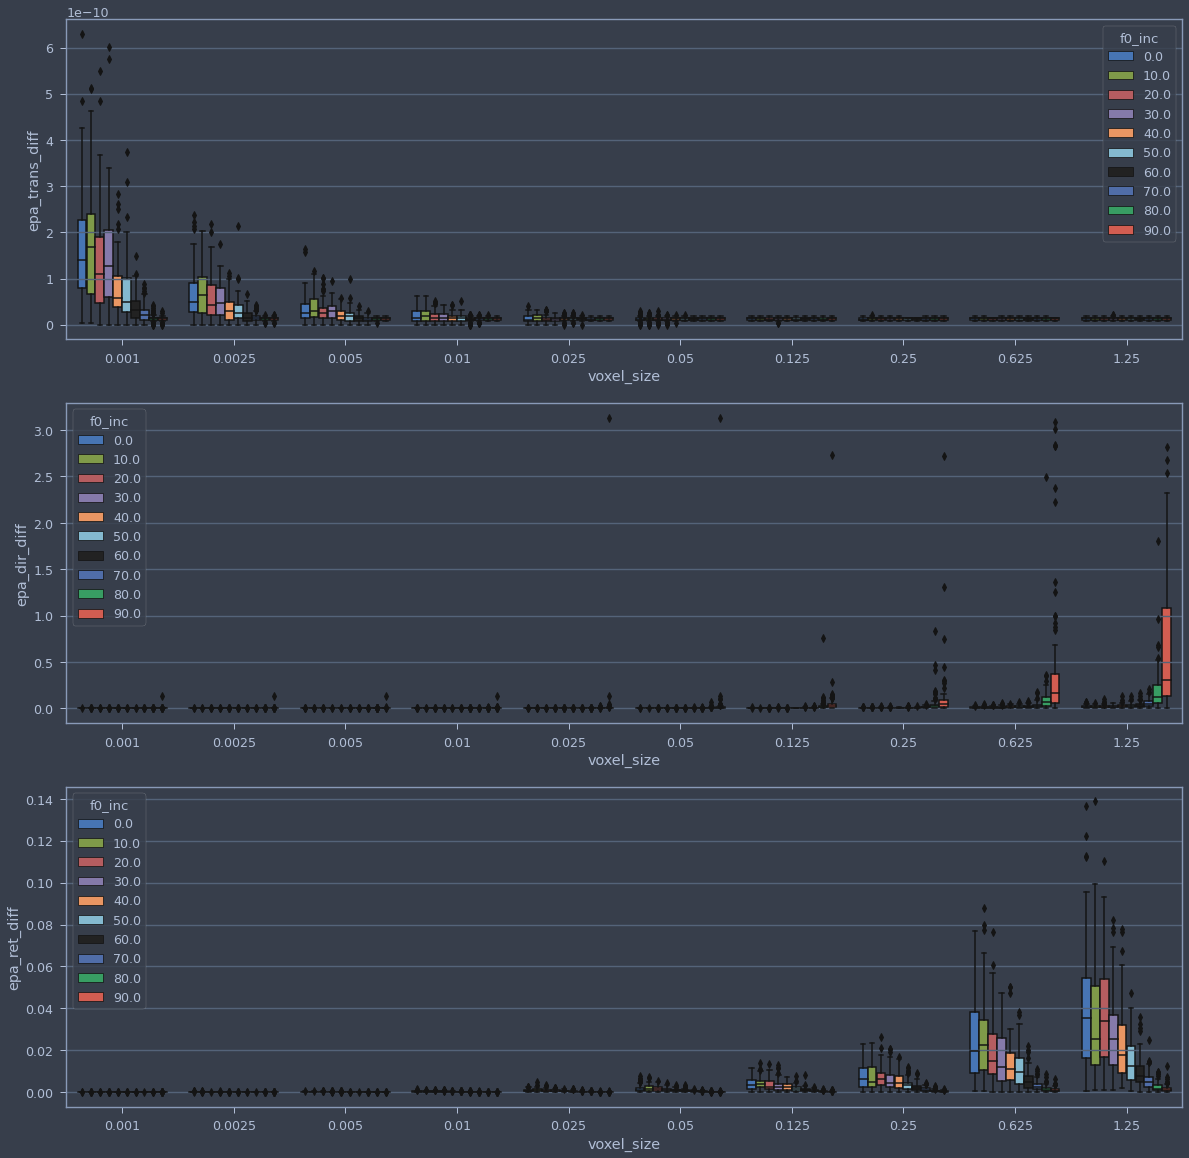

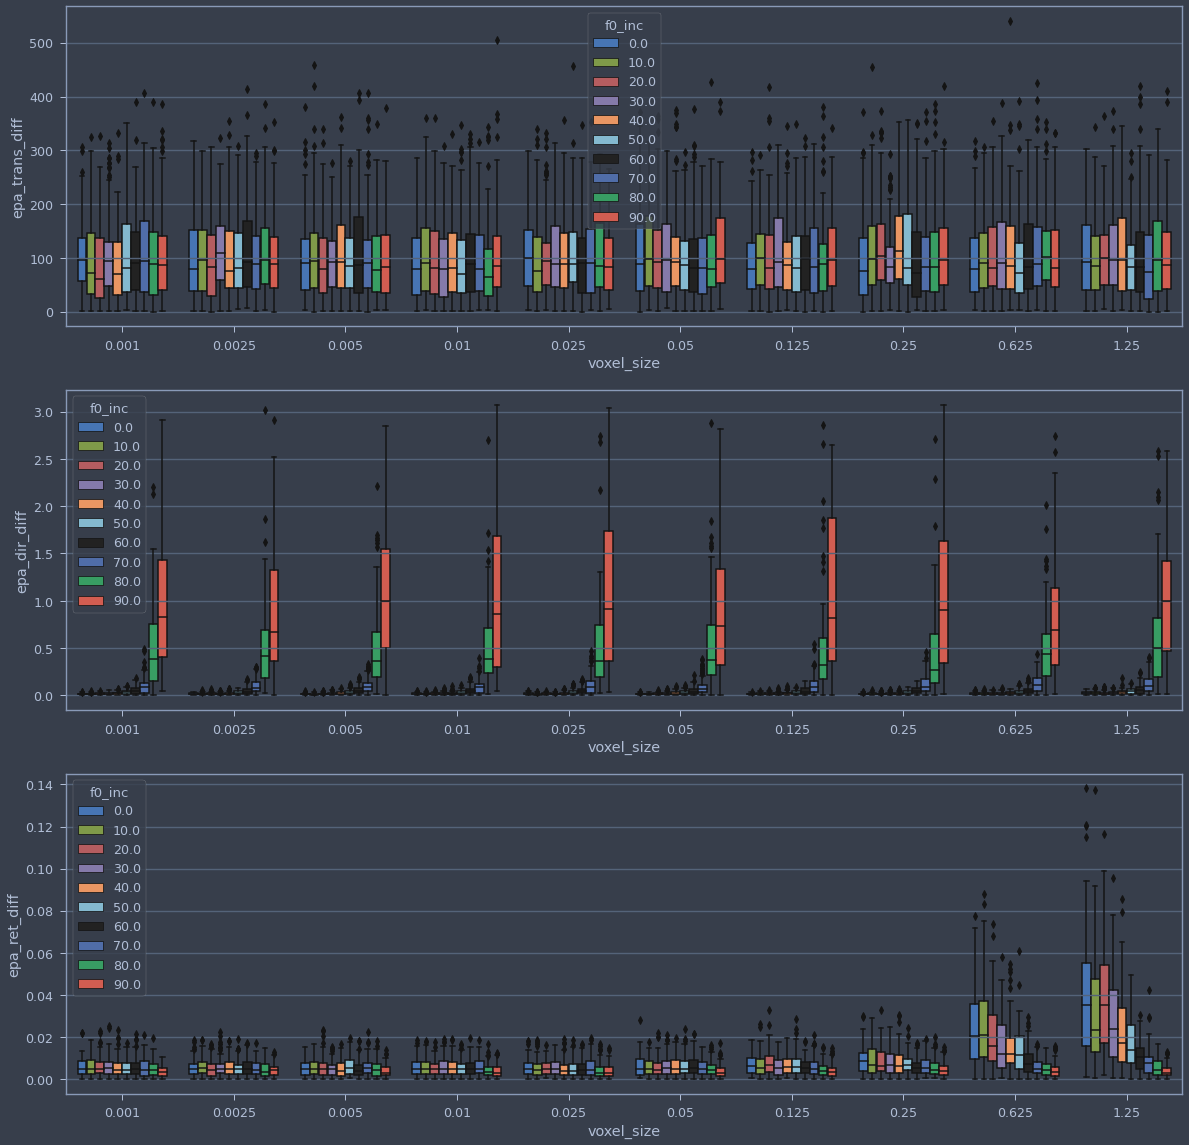

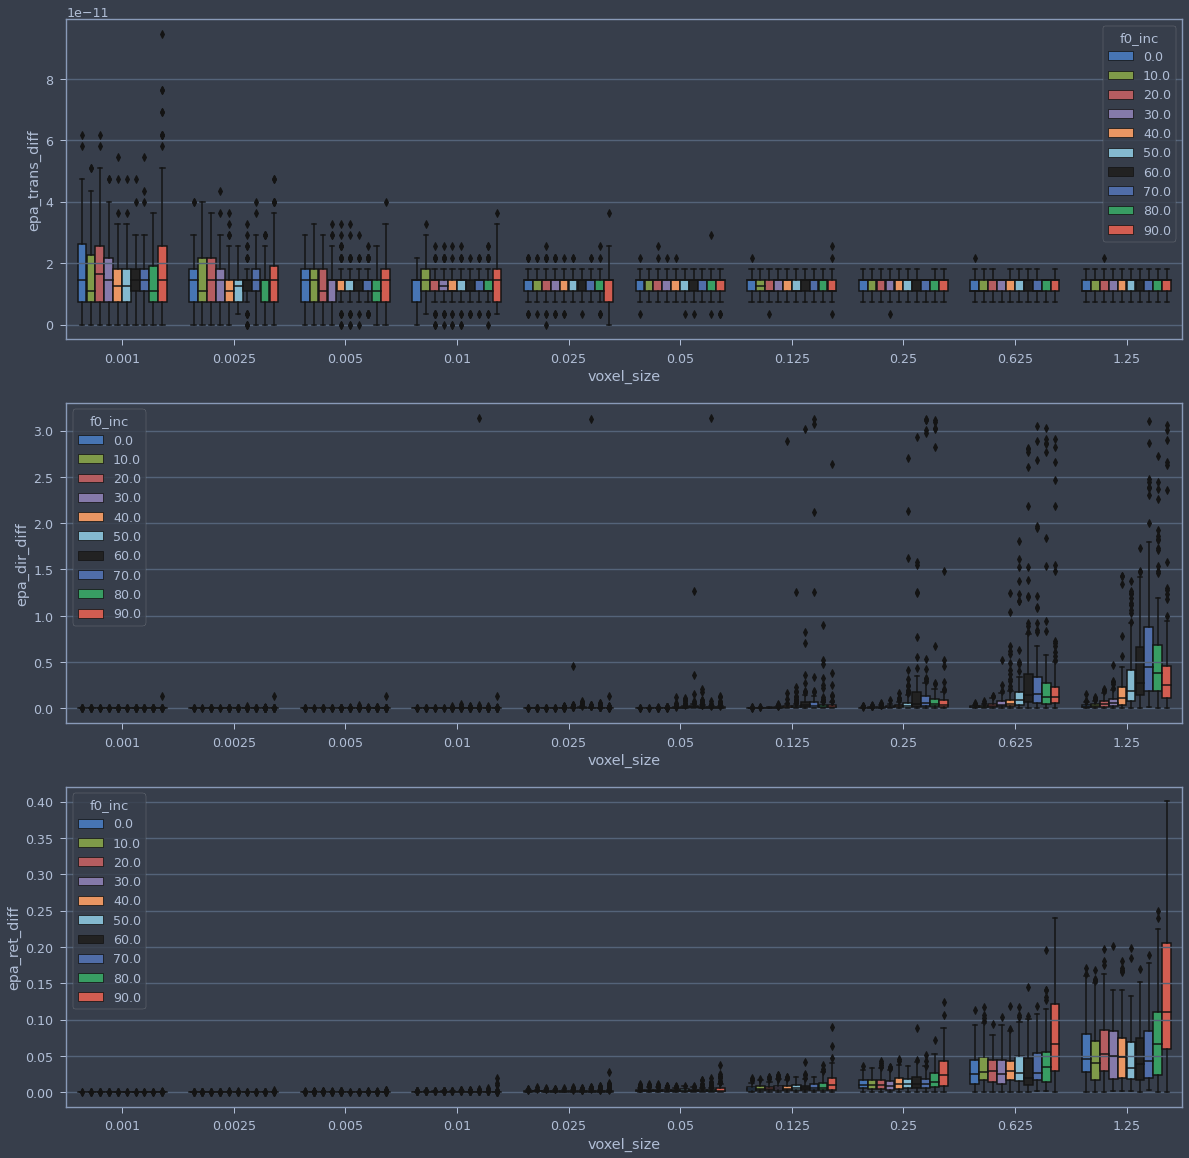

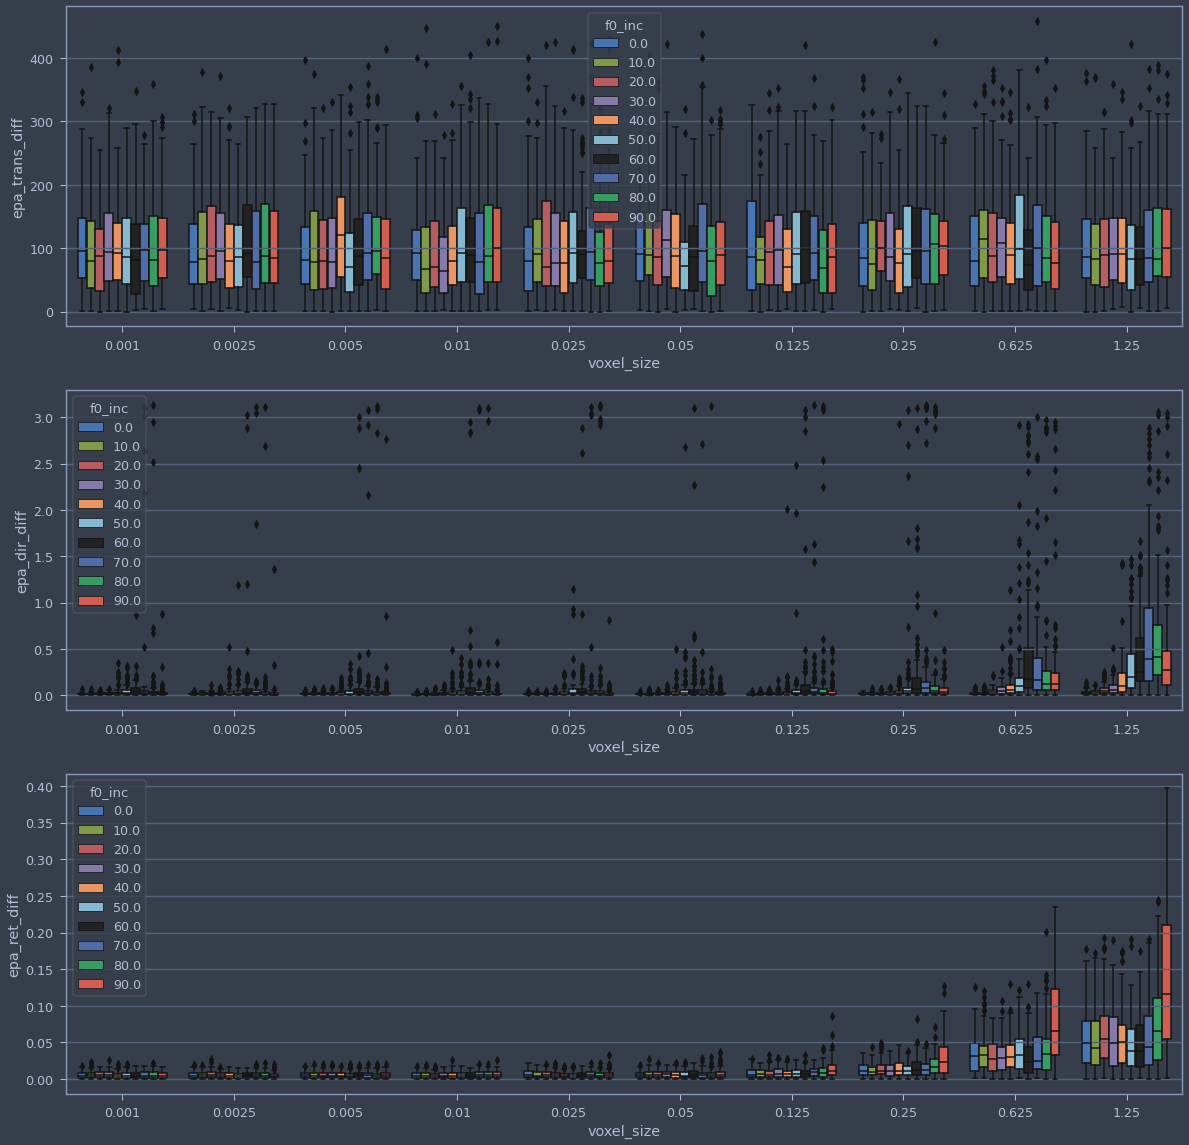

In [6]:
path = "output/rnd_ref_test_1/"
df = pd.read_pickle(os.path.join(path + "rnd_voxel_size_simulation.pkl"))

# df = df[(df.omega == 0.0) & (df.psi == 1.0) & (df.f1_rot == 0.0)]

# # testing
# df = df[(df.f0_inc == 30) & (df.voxel_size==1.25)]

df = df.explode("epa_trans")
df = df.explode("epa_dir")
df = df.explode("epa_ret")
df = df.explode("ref_epa_trans")
df = df.explode("ref_epa_dir")
df = df.explode("ref_epa_ret")

df['epa_dir'] = helper.circular.remap(df['epa_dir'].to_numpy(), np.pi / 2,
                                      -np.pi / 2)
df['ref_epa_dir'] = helper.circular.remap(df['ref_epa_dir'].to_numpy(),
                                          np.pi / 2, -np.pi / 2)

df = df.assign(epa_trans_diff=df.apply(
    lambda x: abs(x.epa_trans - x.ref_epa_trans), axis=1))
df = df.assign(
    epa_dir_diff=df.apply(lambda x: abs(x.epa_dir - x.ref_epa_dir), axis=1))
df = df.assign(
    epa_ret_diff=df.apply(lambda x: abs(x.epa_ret - x.ref_epa_ret), axis=1))

for model in df.model.unique():
    for noise in [0, 1]:
        sub = (df.omega == 0.0) & (df.f1_rot == 0.0) & (df.model == model) & (
            df.voxel_size >= 0.001) & (df.m ==noise)

        fig, axs = plt.subplots(3, 1, figsize=(20, 20))
        axs = np.atleast_2d(axs)
        axs.shape = (3, 1)

        for i, name in enumerate(
            ["epa_trans_diff", "epa_dir_diff", "epa_ret_diff"]):
            ax = axs[i, 0]
            hue = "f0_inc"

            sns.boxplot(x="voxel_size", y=name, hue=hue, data=df[sub], ax=ax)
    #         sns.swarmplot(x="voxel_size",
    #                       y=name,
    #                       hue=hue,
    #                       data=df[sub],
    #                       size=5,
    #                       color=".3",
    #                       linewidth=0,
    #                       dodge=True,
    #                       ax=ax)

    #         ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05))

    #         sns.boxplot(x="voxel_size",
    #                     y=name,
    #                     hue=hue,
    #                     data=df[sub & (df.voxel_size <= 0.125)],
    #                     ax=ax)
    #         sns.swarmplot(x="voxel_size",
    #                       y=name,
    #                       hue=hue,
    #                       data=df[sub & (df.voxel_size <= 0.125)],
    #                       size=5,
    #                       color=".3",
    #                       linewidth=0,
    #                       dodge=True,
    #                       ax=ax)

        fig.savefig(path + f"foo_{model}_{noise}.pdf", bbox_inches='tight')